#  Importing libraries 

In [2]:
import pandas as pd 
import numpy as np 
import os 

C:\Users\Hassan Kerroumi\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
for dirname, _, filenames in os.walk("C:/Users/dell/Downloads/Project/Project/Garbage_Classification"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
#!pip install imutils 

In [5]:
# reading and processing data 
import cv2
import urllib 
import itertools 
import seaborn as sns 
import os, random, glob
import matplotlib.pyplot as plt
from imutils import paths
from sklearn.utils import shuffle
from urllib.request import urlopen 

# ignore warnings 
import warnings 
warnings.filterwarnings('ignore')

# model evaluation 
from sklearn.metrics import confusion_matrix, classification_report 

from tensorflow.keras.utils import to_categorical 
import tensorflow as tf 

#  Reading the dataset 

In [6]:
dir_path = "../../Datasets/Garbage_Classification/Garbage classification"

In [7]:
target_size = (224, 224)
waste_labels = {'cardboard':0,'glass':1, 'metal':2, 'paper':3, 'plastic':4, 'trash':5}

In [8]:
def load_dataset(path):
    """ 
  It reads the images in the directory and creates their labels.

  Parameters:

  path: Refers to the directory where the images are located.
  Return:
   x: It stores the matrix information of the images.
  labels: A list that holds the class information of each image.
  """
    x = []
    labels = []
    # It lists and sorts the images in the specified path
    image_paths = sorted(list(paths.list_images(path)))
   
    for image_path in image_paths :
        # The images in the specified path are read using the OpenCV library
        img = cv2.imread(image_path)
        # resize the read image 
        img = cv2.resize(img, target_size)
        # the resized images are added to the x list
        x.append(img)
         # When each path is split by '/', the second-to-last element of the resulting list represents the label
        label = image_path.split(os.path.sep)[-2]
        
        # The label is created by retrieving the corresponding value for the given key from the `waste_labels`

        # dictionary, which contains the numerical representations of the captured labels
        labels.append(waste_labels[label])
        # the dataset is shuffled randomly
    x, labels = shuffle(x, labels, random_state = 42)
    print(f'X size : {np.array(x).shape}')
    print(f'Number of label classes {np.unique(labels)}, Number of observation in the dataset : {len(labels)}')
    
    return np.array(x), np.array(labels) 


In [9]:
x, labels = load_dataset(dir_path)

X size : (0,)
Number of label classes [], Number of observation in the dataset : 0


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test_, y_train, y_test_ = train_test_split(
    x, labels, test_size=0.3, random_state=42
)


#print(f"Train set size: {len(X_train)}")
#print(f"Test set size: {len(X_test)}")


ValueError: With n_samples=0, test_size=0.3 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
#X_train,y_train = load_dataset(dir_path_train)
#X_test,y_test = load_dataset(dir_path_test)
#X_val,y_val = load_dataset(dir_path_val)

In [ ]:
input_shape = (np.array(X_train[0]).shape[1], np.array(X_train[0]).shape[0], 3)
print(input_shape)

In [ ]:
np.array(list(list(waste_labels.keys())))

# Sample from dataset

In [ ]:
def visualize_img(image_batch, label_batch,n):
    """  Parameters:



  image_batch: Storing the matrix information of the images



  label_batch: A list that stores the class information of the image

    """
    plt.figure(figsize=(15,65))
    j = 0
    for n in range(100+n):
        ax = plt.subplot(20,5,j+1)
        j +=1
        plt.imshow(image_batch[n])
        plt.title(np.array(list(waste_labels.keys())) [to_categorical(label_batch, num_classes=6)[n]==1][0].title())

In [ ]:
visualize_img(X_train, y_train,0)

# Data augmentation 
- this step means generate more data using the exsting data 

In [ ]:
X_train.shape

# Modeling
- Create a CNN model 

In [ ]:
base_model = tf.keras.applications.ResNet50(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=(224,224,3),
    pooling='avg',
    #pooling = None,
    #classes,
    classifier_activation=None
)


In [ ]:
base_model.summary()

In [ ]:
x_train = base_model.predict(X_train)
x_test = base_model.predict(X_test)

In [ ]:
print(x_train.shape,x_test.shape)

# Testing

In [35]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
#from sklearn.decomposition import PCA

In [37]:
clf = SVC(kernel='rbf', C=1, probability=True)

In [38]:
clf.fit(x_train, y_train)

SVC(C=1, probability=True)

In [39]:
y_pred_test = clf.predict(x_test)

In [40]:
accuracy = accuracy_score(y_test, y_pred_test)

In [41]:
print(f"Test Accuracy: {accuracy:.2f}")

Test Accuracy: 0.82


In [42]:
y_proba1 = clf.predict_proba(x_test)

# ROC and DET curves 

In [43]:
from sklearn.preprocessing import label_binarize


def evaluate(ytrue, ypred):
    acc = 0
    m = ytrue.shape[0]
    for i in range(m):
        if ytrue[i] == ypred[i]:
            acc += 1 
    return acc/m

def CourbeROC(y_pred_binarise, y_proba):
    # Initialisation des variables
    seuil = np.max(y_proba) + 0.01 if np.max(y_proba) != 1 else 1
    pas = seuil / y_pred_binarise.shape[0]  # Calcul du pas
    mins = np.min(y_proba)
    pos = max(1, len(y_pred_binarise[y_pred_binarise == 1]))
    neg = max(1, len(y_pred_binarise[y_pred_binarise == 0]))
    
    # TPR (True Positive Rate) et FPR (False Positive Rate)
    TPR = []
    FPR = []
    seuils = []
    
    # Calcul de TPR et FPR pour différents seuils
    while seuil > mins:
        TPR.append(len(y_pred_binarise[(y_pred_binarise == 1) & (y_proba >= seuil)]) / pos)
        FPR.append(len(y_pred_binarise[(y_pred_binarise == 0) & (y_proba >= seuil)]) / neg)
        seuils.append(seuil)
        seuil -= pas
    return np.array(TPR), np.array(FPR)

def roc_class(y_true,y_proba1,title,n_classes = 6,labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']):

    y_pred = np.argmax(y_proba1,axis = 1)
    # Binarize the true labels for multi-class ROC
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

    # Initialize plots
    plt.figure(figsize=(7, 7))

    # ROC Curve
    for i in range(n_classes):
        # Compute ROC curve and AUC for each class
        class_mask = (y_true == i)  # Boolean mask for selecting samples of class i
        ytrue_class = y_true[class_mask]
        ypred_class = y_pred[class_mask]

        # Apply evaluate function to the current class
        acc = evaluate(ytrue_class, ypred_class)
        tpr, fpr = CourbeROC(y_true_bin[:, i], y_proba1[:, i])
        plt.plot(fpr, tpr, label=f'{labels[i]} (AUC = {acc:.2f})')

    plt.plot([0, 1], [0, 1], 'r--', label='Random Classifier')
    plt.title(title)
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.legend(loc='lower right')
    plt.grid()

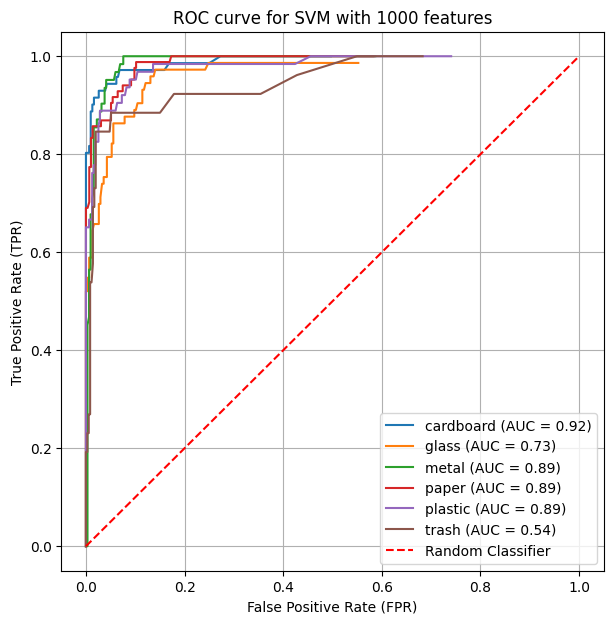

In [45]:
roc_class(y_test,y_proba1,title="ROC curve for SVM with 1000 features")

In [50]:
from scipy.stats import norm
def DETcurve(ytest, yproba, title, n_classes = 6,labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']):
    y_true_bin = label_binarize(ytest, classes=np.arange(n_classes))

    # DET Curve
    plt.figure(figsize=(7, 7))
    for i in range(n_classes):
        # Compute ROC curve (to get FPR and TPR)
        tpr, fpr= CourbeROC(y_true_bin[:, i], y_proba1[:, i])
        fnr = 1 - tpr  

        # Transform FPR and FNR to normal deviates
        fpr_norm = norm.ppf(fpr)
        fnr_norm = norm.ppf(fnr)

        # Handle invalid values (due to ppf on 0 or 1)
        fpr_norm[np.isinf(fpr_norm)] = np.nan
        fnr_norm[np.isinf(fnr_norm)] = np.nan

        plt.plot(fpr_norm, fnr_norm, label=labels[i])

    plt.title(title)
    plt.xlabel('False Positive Rate (FPR) (normal deviate)')
    plt.ylabel('False Negative Rate (FNR) (normal deviate)')
    plt.grid(which='both')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

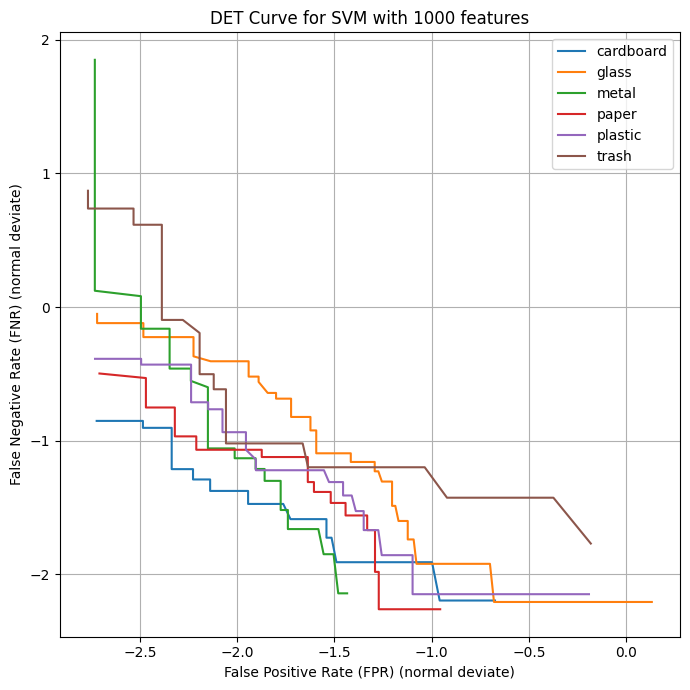

In [51]:
DETcurve(y_test, y_proba1, "DET Curve for SVM with 1000 features")

In [52]:
from joblib import dump, load

# Save the model
#dump(clf, 'svm.joblib')

# Load the model
svm = load('svm.joblib')


# With 512 features

In [53]:
from tensorflow.keras.applications import  VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

In [54]:
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = VGG_model.output
x = GlobalAveragePooling2D()(x)
VGG16_model = Model(inputs=VGG_model.input, outputs=x)

# Predict features
xtrain_features = VGG16_model.predict(X_train)
xtest_features = VGG16_model.predict(X_test)


56/56 ━━━━━━━━━━━━━━━━━━━━ 332s 6s/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 77s 6s/step


In [55]:
xtrain_features.shape

(1768, 512)

In [56]:
clf = SVC(kernel='rbf', C=1, probability=True)

In [57]:
clf.fit(xtrain_features, y_train)

SVC(C=1, probability=True)

In [58]:
y_pred_test = clf.predict(xtest_features)

In [59]:
accuracy = accuracy_score(y_test, y_pred_test)

In [60]:
print(f"Test Accuracy: {accuracy:.2f}")

Test Accuracy: 0.87


In [61]:
y_proba2 = clf.predict_proba(xtest_features)

# ROC and DET curves 

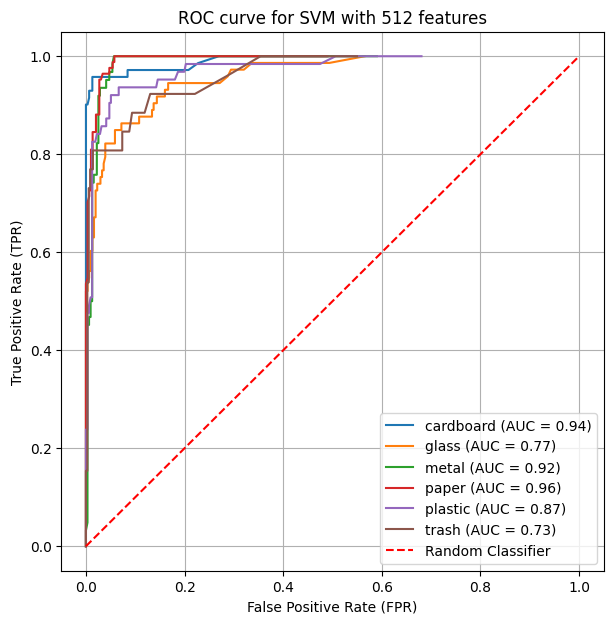

In [62]:
roc_class(y_test,y_proba2,title="ROC curve for SVM with 512 features")

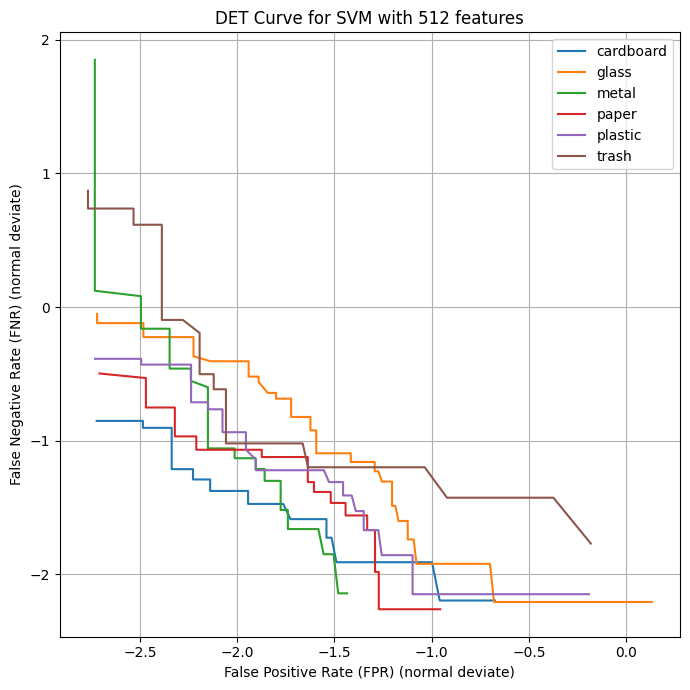

In [63]:
DETcurve(y_test, y_proba1, "DET Curve for SVM with 512 features")

# Evaluation 

In [66]:
img = cv2.imread("../imagesTest/plas1.jpg")

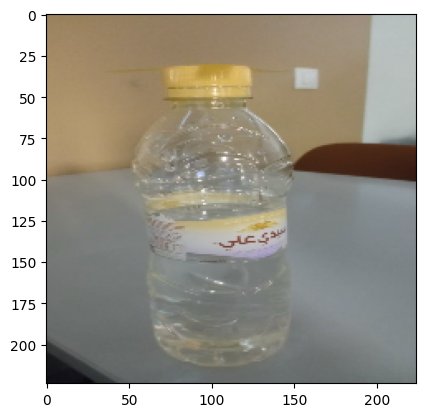

In [67]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt 
img_x = []
#m = load_model("Res_Model_1.keras")
#img = x[1815]
#img = cv2.imread("C:/Users/dell/Pattern-Recognition - Copy/Pattern-Recognition - Copy/imagesTest/news.jpg")
img = cv2.resize(img, (224,224)) / 255.0
img_x.append(img)
img_x = np.array(img_x)
img_x.shape
plt.imshow(img)

In [70]:
s  = VGG16_model.predict(img_x)

y_pred = clf.predict(s.reshape(s.shape[0], -1))
print(y_pred[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
4


In [71]:
predicted_class_index = y_pred[0]

predicted_label = next((key for key, value in waste_labels.items() if value == predicted_class_index), None)

print(f"Predicted class index: {predicted_class_index}")
print(f"Predicted class name: {predicted_label}")

Predicted class index: 4
Predicted class name: plastic
